# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                        transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.ToPILImage(),
                                       #transforms.RandomRotation(degrees = (-5,5)),
                                       transforms.RandomRotation((-8.0, 8.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train_transforms

Compose(
    Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR)
    ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
    RandomRotation(degrees=(-8.0, 8.0), resample=False, expand=False)
    ToTensor()
    Normalize(mean=(0.1307,), std=(0.3081,))
)

# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=256, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=256)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [0]:
# # We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# # Let's visualize some of the images


# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [0]:
# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(.1)
        ) # output_size = 24
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=24, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(.1)
        ) # output_size = 9
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 4
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 4

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(4, 4), padding=0, bias=False),
            #nn.ReLU()
        ) # output_size = 2
       
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        #x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
              ReLU-3           [-1, 12, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,728
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
           Dropout-7           [-1, 16, 24, 24]               0
            Conv2d-8           [-1, 32, 22, 22]           4,608
       BatchNorm2d-9           [-1, 32, 22, 22]              64
             ReLU-10           [-1, 32, 22, 22]               0
        MaxPool2d-11           [-1, 32, 11, 11]               0
           Conv2d-12           [-1, 24, 11, 11]             768
      BatchNorm2d-13           [-1, 24, 11, 11]              48
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    
    # Print Learning Rate
    
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    #scheduler.step()
    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    scheduler.step(epoch)
    train(model, device, train_loader, optimizer, epoch)
    
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    test(model, device, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/235 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.14353032410144806 Batch_id=234 Accuracy=94.46: 100%|██████████| 235/235 [00:17<00:00, 13.33it/s]

Epoch: 0 LR: [0.1]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9866/10000 (98.66%)

EPOCH: 1


Loss=0.0847524031996727 Batch_id=234 Accuracy=97.97: 100%|██████████| 235/235 [00:17<00:00, 13.17it/s]

Epoch: 1 LR: [0.1]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9880/10000 (98.80%)

EPOCH: 2


Loss=0.0047973692417144775 Batch_id=234 Accuracy=98.34: 100%|██████████| 235/235 [00:17<00:00, 13.16it/s]

Epoch: 2 LR: [0.1]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.047033894807100296 Batch_id=234 Accuracy=98.42: 100%|██████████| 235/235 [00:17<00:00, 13.34it/s]

Epoch: 3 LR: [0.1]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


Loss=0.01912464201450348 Batch_id=234 Accuracy=98.59: 100%|██████████| 235/235 [00:17<00:00, 13.19it/s]

Epoch: 4 LR: [0.1]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.012696807272732258 Batch_id=234 Accuracy=98.76: 100%|██████████| 235/235 [00:17<00:00, 13.06it/s]

Epoch: 5 LR: [0.1]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9891/10000 (98.91%)

EPOCH: 6


Loss=0.025929847732186317 Batch_id=234 Accuracy=99.01: 100%|██████████| 235/235 [00:18<00:00, 12.94it/s]

Epoch: 6 LR: [0.0010000000000000002]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.009960994124412537 Batch_id=234 Accuracy=99.13: 100%|██████████| 235/235 [00:18<00:00, 12.86it/s]

Epoch: 7 LR: [0.010000000000000002]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.016216814517974854 Batch_id=234 Accuracy=99.21: 100%|██████████| 235/235 [00:17<00:00, 13.23it/s]

Epoch: 8 LR: [0.010000000000000002]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)

EPOCH: 9


Loss=0.04262472689151764 Batch_id=234 Accuracy=99.18: 100%|██████████| 235/235 [00:17<00:00, 13.19it/s]

Epoch: 9 LR: [0.010000000000000002]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.0014951726188883185 Batch_id=234 Accuracy=99.23: 100%|██████████| 235/235 [00:17<00:00, 13.08it/s]

Epoch: 10 LR: [0.010000000000000002]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.04157378152012825 Batch_id=234 Accuracy=99.18: 100%|██████████| 235/235 [00:17<00:00, 13.29it/s]

Epoch: 11 LR: [0.010000000000000002]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.21401359140872955 Batch_id=234 Accuracy=99.23: 100%|██████████| 235/235 [00:18<00:00, 12.91it/s]

Epoch: 12 LR: [0.00010000000000000003]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.01936381496489048 Batch_id=234 Accuracy=99.27: 100%|██████████| 235/235 [00:17<00:00, 13.20it/s]

Epoch: 13 LR: [0.0010000000000000002]



  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.0039743781089782715 Batch_id=234 Accuracy=99.22: 100%|██████████| 235/235 [00:18<00:00, 13.04it/s]

Epoch: 14 LR: [0.0010000000000000002]



Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)



Text(0.5, 1.0, 'Test Accuracy')

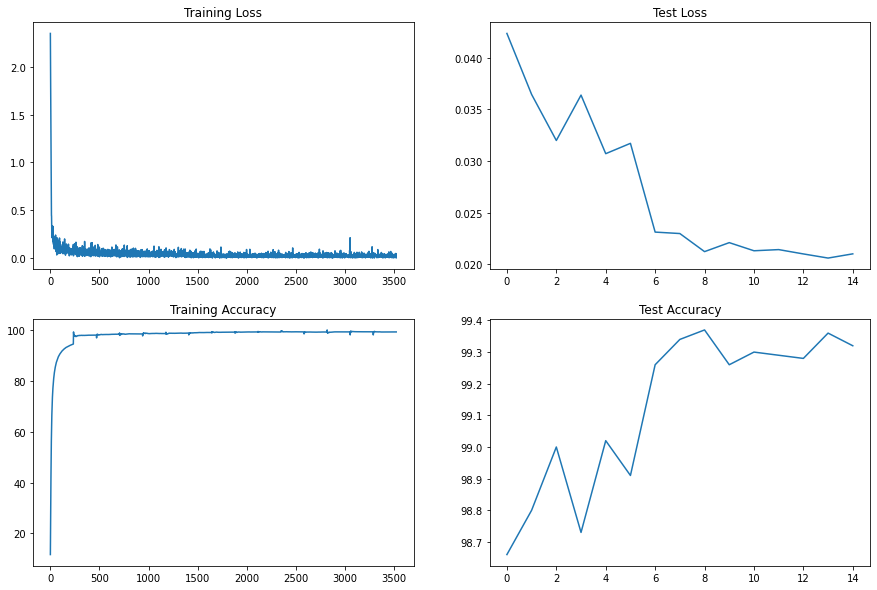

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")